Стационарность 

Слабо стационарный процесс: 
$$
E[y_t] = \mu
$$
$$
cov(y_t, y_{t-k}) = \gamma_k
$$
Стационарные процессы интересны с точки зрения прогнозирования их во времени, так как чем меньше характеристик временного ряда изменяется во времени, тем проще его прогнозировать

#### Теорема Вольда :

Любой слабо стационарный процесс можно разложить на прогнозируемую часть и $MA(\infty)$ - процесс

#### Процесс белого шума:

Процес белого шума сам по себе является частным случаем стационарного ряда и характеризуется следующими характеристиками:

$$
E[y_t] = 0
$$
$$
Var[y_t] = \sigma ^ 2
$$
$$
cov(y_t, y_{t-k}) = 0 \; \forall k \ne 0
$$

####  Создадим простой процесс белого шума -- последовательность N(0, 1) случайных величин

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from scipy.stats import norm, chi2
from sktime.utils.plotting import plot_correlations

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (20, 5)

<AxesSubplot:title={'center':'White Noise process'}, xlabel='Time'>

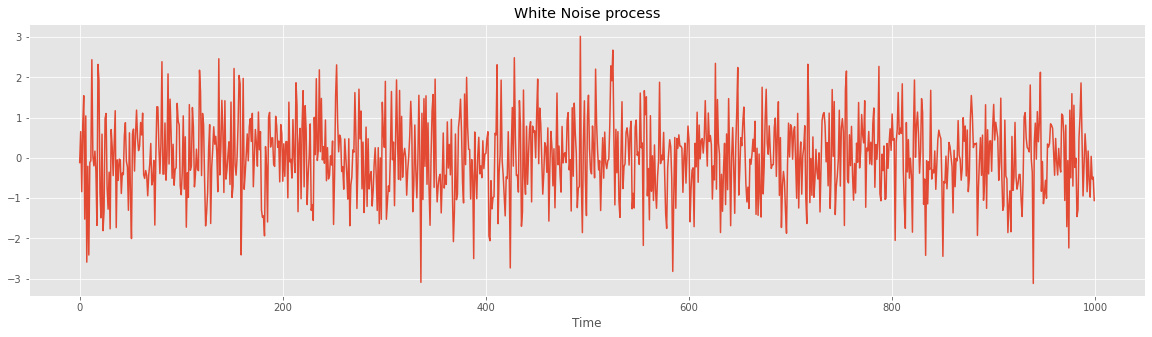

In [2]:
n_obs = 1000
sample = pd.Series(np.random.normal(size = n_obs))
plt.title("White Noise process")
plt.xlabel("Time")
sample.plot()


In [3]:
# Найдем оценку мат ожидания
mu_hat = np.mean(sample)
mu_hat

0.02444861459467464

In [8]:
# p-value гипотезы о равенстве среднего нулю
norm.cdf(mu_hat * np.sqrt(n_obs) / np.std(sample)) 

0.7899193214369906

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

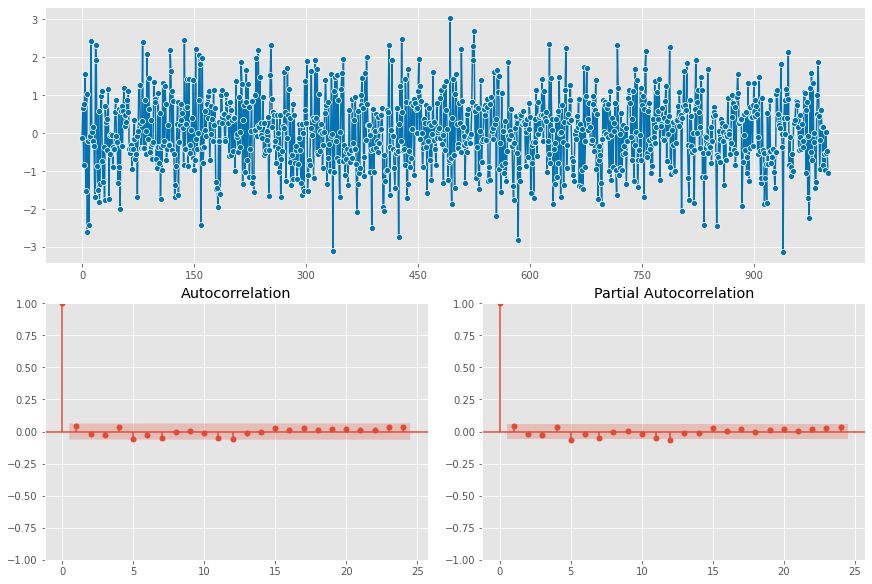

In [9]:
# Проведем тест на автокорряляцию
plot_correlations(sample)

Portmanteau test:

$$
H_0 : \hat \rho_{1} = \ldots = \hat \rho_{m} = 0
$$
$$
H_1: \exist \; \hat \rho_i \ne 0
$$ 
$$
Q(m) = T \sum_{k = 1}^{m}\rho_k \sim \chi^2_m
$$

$$
m \approx ln(T)
$$

In [10]:
# Проведем статистический тест (Portmanteau test)
m = 10
corrs = [np.corrcoef(sample [k:], sample.shift(k)[k:])[0][1] for k in range(1, m + 1)]
test_stat = np.sum(np.square(corrs)) * n_obs

In [11]:
# p_value 
1 - chi2.cdf(test_stat, 10)

0.3355912299828221

Статистика Лююнга-Бокса:
$$
Q(m) =T(T+2)\sum_{k = 1}^{m} \dfrac{\hat \rho ^ 2}{T-1} \sim \chi^2_m
$$

In [12]:
test_stat = np.sum(np.square(corrs) / n_obs - 1) * n_obs * (n_obs + 2)

# p_value 
1 - chi2.cdf(test_stat, 10)

1.0

Тестирование остатков на автокорреляцию статистиками, которые описаны выше, не совсем корректно. Можно почитать [здесь](https://stats.stackexchange.com/questions/148004/testing-for-autocorrelation-ljung-box-versus-breusch-godfrey)

## MA process

MA(k) model :
$$
y_t = \mu + \epsilon_t + \alpha_1 \epsilon_{t-1} + \ldots + \alpha_q \epsilon_{t-q}
$$

In [13]:
from statsmodels.api import tsa

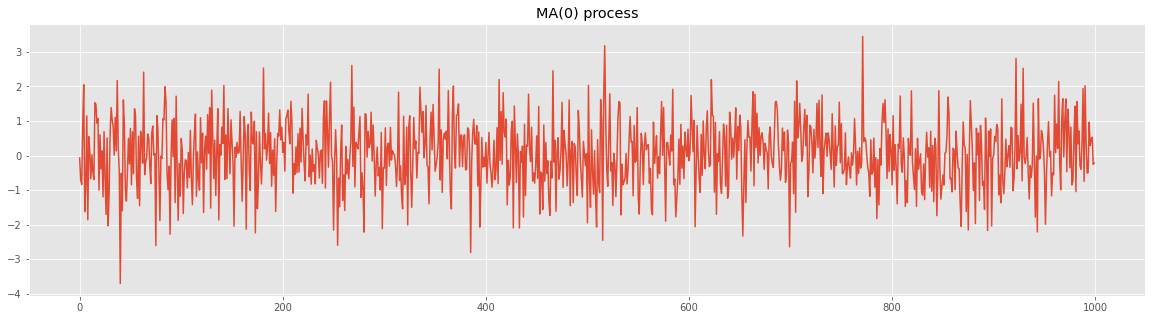

In [14]:
wn_process = tsa.ArmaProcess()
sample = pd.Series(wn_process.generate_sample(nsample=1000, burnin = 1000))
sample.plot()
plt.title('MA(0) process');

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

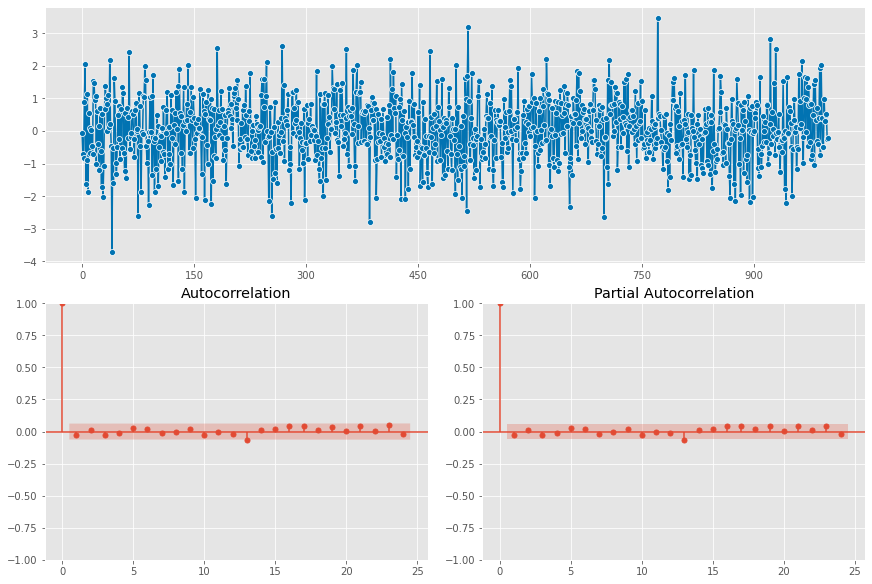

In [15]:
plot_correlations(sample)

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

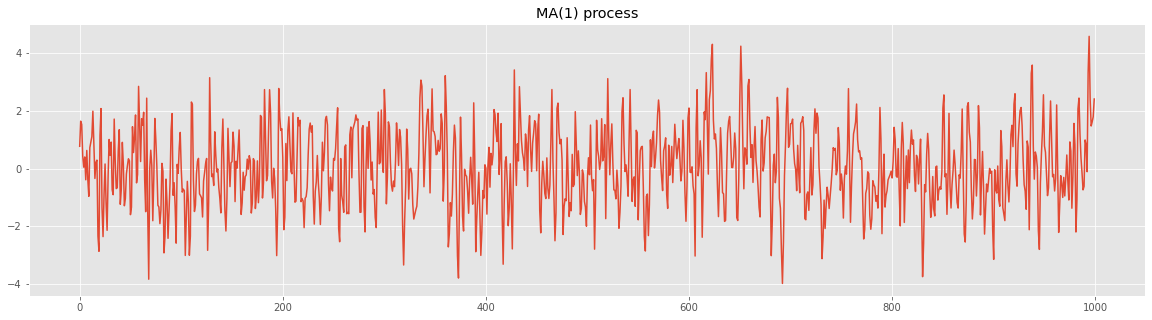

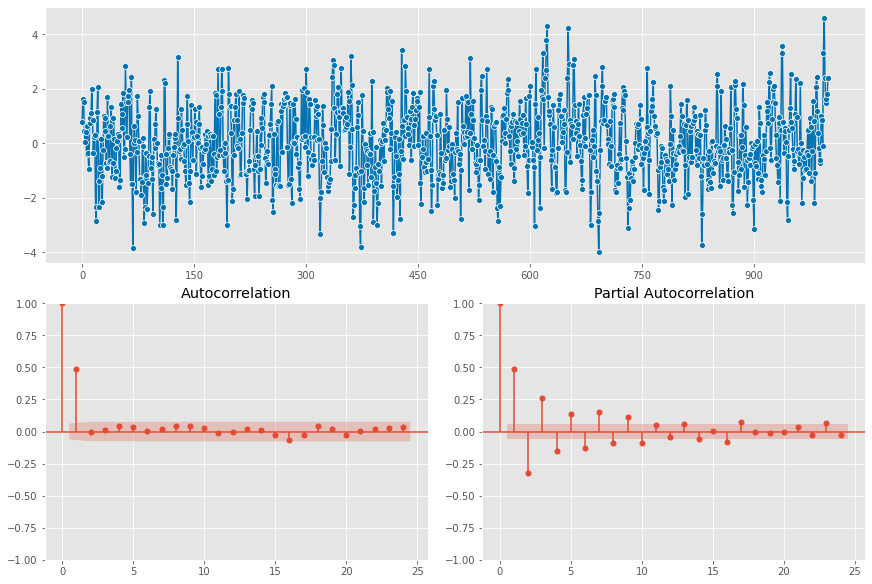

In [17]:
ma_process = tsa.ArmaProcess(ma=[1, 0.9])
sample = pd.Series(ma_process.generate_sample(nsample=1000, burnin = 10000))
sample.plot()
plt.title('MA(1) process');
plot_correlations(sample)

MA(5)
$$
y_t = \mu + \epsilon_t + 0.9 \epsilon_{t-1} + 0.8 \epsilon_{t-2} + 0.5 \epsilon_{t-3} + 0.6 \epsilon_{t-4} + 0.2 \epsilon_{t-5}
$$

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

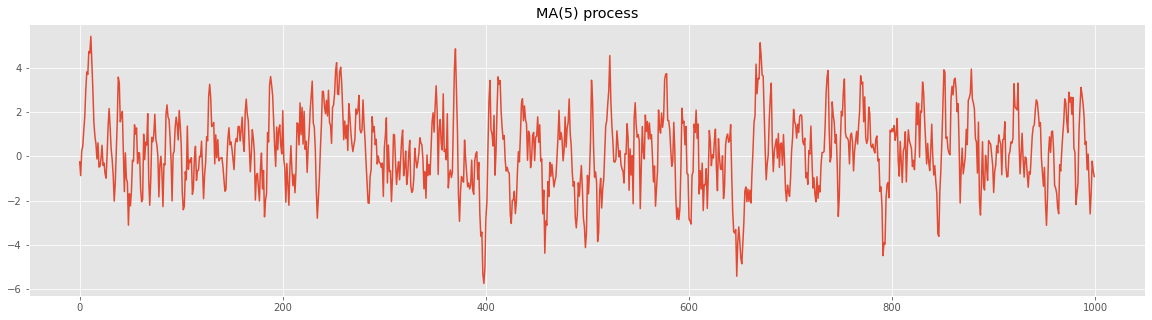

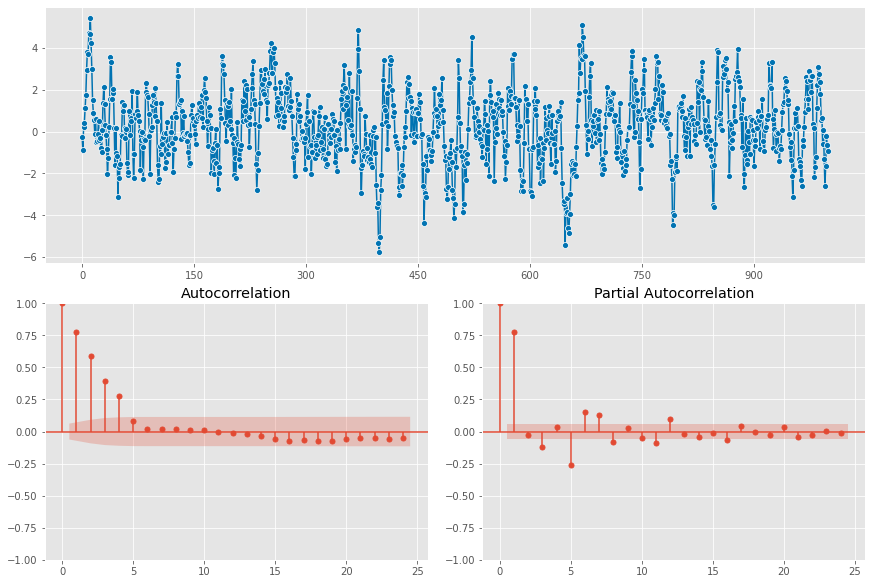

In [19]:
ma_process = tsa.ArmaProcess(ma=[1, 0.9, 0.8, 0.5, 0.6, 0.2])
sample = pd.Series(ma_process.generate_sample(nsample=1000, burnin = 1000))
sample.plot()
plt.title('MA(5) process');
plot_correlations(sample)

# Прогноз MA(q) - процессов


##### Замечание: прогноз больше чем на q шагов - выходит на константу. Дисперсия раздывается с каждым последующим прогнозом, но также выходит на константу

In [22]:
# Оценим на последней выборки MA(1) процесс
from sktime.forecasting.arima import ARIMA
forecaster = ARIMA(order = (0, 0, 1))
forecaster.fit(sample)
resid = forecaster.predict_residuals()
forecaster.summary()

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sktime\forecasting\base\adapters\_pmdarima.py:110: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_pred = pd.Series(index=fh_abs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -1692.249
Date:                Mon, 27 Jun 2022   AIC                           3390.498
Time:                        13:39:48   BIC                           3405.221
Sample:                             0   HQIC                          3396.094
                               - 1000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2497      0.065      3.840      0.000       0.122       0.377
ma.L1          0.5590      0.025     22.297      0.000       0.510       0.608
sigma2         1.7267      0.076     22.674      0.000       1.577       1.876
===================================================================================
Ljung-Box (L1) (Q):                 109.26   Jarque-Bera (JB):                 2.84
Prob(Q):                              0.00   Prob(JB):                         0.24
Heteroskedasticity (H):               1.04   Skew:                            -0.12
Prob(H) (two-sided):                  0.69   Kurtosis:                         3.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

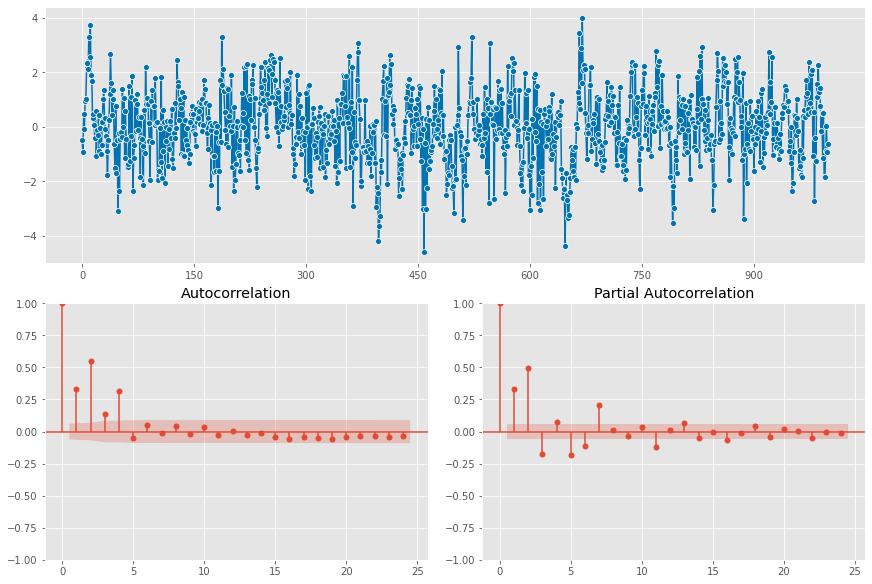

In [23]:
# На основании остатков посмотрим, хорошо ли мы оценили модель
plot_correlations(resid)

In [24]:
from sktime.forecasting.arima import ARIMA
forecaster = ARIMA(order = (0, 0, 4))
forecaster.fit(sample)
resid = forecaster.predict_residuals()
forecaster.summary()

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sktime\forecasting\base\adapters\_pmdarima.py:110: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_pred = pd.Series(index=fh_abs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(0, 0, 4)   Log Likelihood               -1440.415
Date:                Mon, 27 Jun 2022   AIC                           2892.831
Time:                        13:41:15   BIC                           2922.277
Sample:                             0   HQIC                          2904.022
                               - 1000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2481      0.105      2.369      0.018       0.043       0.453
ma.L1          0.7473      0.029     26.045      0.000       0.691       0.803
ma.L2          0.6909      0.035     19.514      0.000       0.621       0.760
ma.L3          0.3218      0.036      8.903      0.000       0.251       0.393
ma.L4          0.4466      0.027     16.253      0.000       0.393       0.500
sigma2         1.0421      0.049     21.481      0.000       0.947       1.137
===================================================================================
Ljung-Box (L1) (Q):                   8.94   Jarque-Bera (JB):                 5.66
Prob(Q):                              0.00   Prob(JB):                         0.06
Heteroskedasticity (H):               1.17   Skew:                            -0.17
Prob(H) (two-sided):                  0.15   Kurtosis:                         2.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

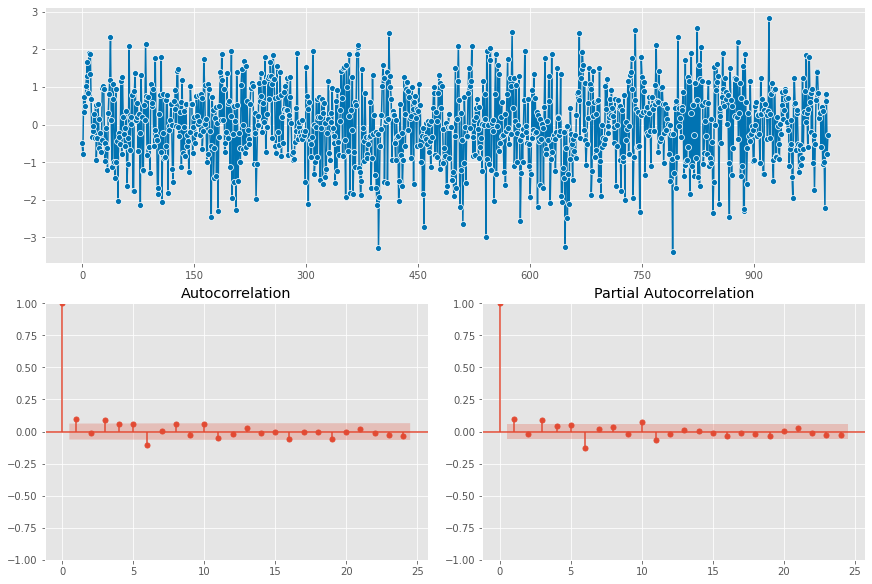

In [25]:
plot_correlations(resid)

In [26]:
# Сравним прогнозы 2 моделей 
from sktime.forecasting.model_selection import temporal_train_test_split
y_train, y_test = temporal_train_test_split(sample, test_size = 10)

forecaster_1 = ARIMA(order = (0, 0, 2))
forecaster_2 = ARIMA(order = (0, 0, 5))
forecaster_1.fit(y_train)
forecaster_2.fit(y_train)

ARIMA(order=(0, 0, 5))

<AxesSubplot:>

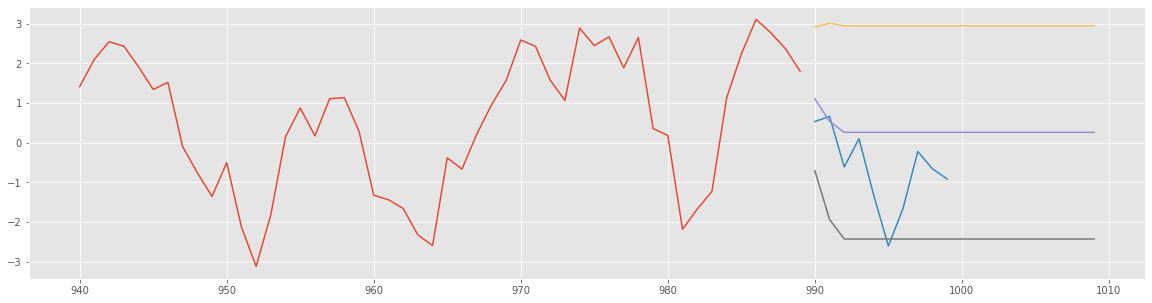

In [38]:
y_train.tail(50).plot()
y_test.plot()
forecaster_1.predict(list(range(1, 21))).plot()
forecaster_1.predict_interval(list(range(1, 21)))["Coverage"][0.9].lower.plot()
forecaster_1.predict_interval(list(range(1, 21)))["Coverage"][0.9].upper.plot()

<AxesSubplot:>

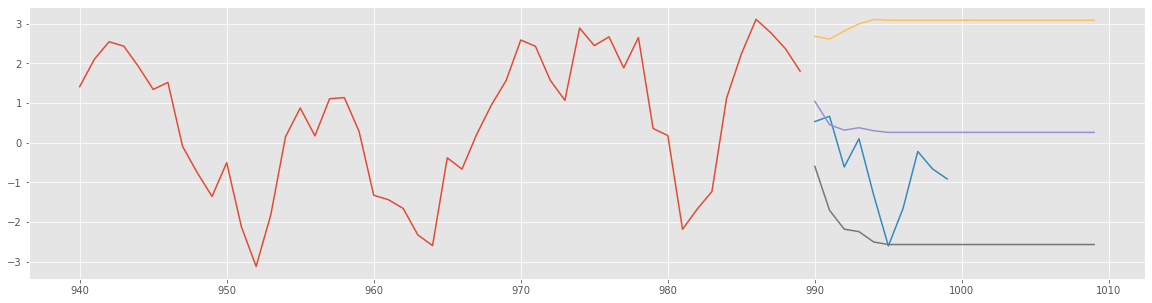

In [41]:
y_train.tail(50).plot()
y_test.plot()
forecaster_2.predict(list(range(1, 21))).plot()
forecaster_2.predict_interval(list(range(1, 21)))["Coverage"][0.9].lower.plot()
forecaster_2.predict_interval(list(range(1, 21)))["Coverage"][0.9].upper.plot()